# Imports

In [1]:
import gymnasium as gym
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gymnasium.wrappers import FlattenObservation

env_train = gym.make('gym_environment:gym_environment/SimpleBattery', days=1, predict=False)
env_train = FlattenObservation(env_train)

# setup plots
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# DQN Model

In [2]:
"""
Transition: named tuple representing a single transition in the environment
    maps the (state, action) pairs to their (next_state,reward) result

ReplayMemory: a cyclic buffer that holds the transitions oberved recetly.
    Also has a .sample() method for selecting a random batch of transition for training

"""

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    

class GetLSTMoutput(nn.Module):
    def forward(self, x):
        out, _ = x
        return out


""" Custom DQN module using Q-learning """
class DQN(nn.Module):   
    def __init__(self, observation_shape, n_actions, env, EPS_END, EPS_START, EPS_DECAY):
        super(DQN, self).__init__()

        # Innit variables
        self.env = env
        self.EPS_END = EPS_END
        self.EPS_START = EPS_START
        self.EPS_DECAY = EPS_DECAY

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=observation_shape[0], out_channels=32, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
        )
        # Calculate the shape of the output from the convolutional layers
        conv_output_size = self._get_conv_output_size(observation_shape)
        
        self.rnn_layers = nn.Sequential(
            nn.LSTM(input_size=conv_output_size, hidden_size=64, batch_first=True),
            GetLSTMoutput(),
            nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def _get_conv_output_size(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.conv_layers(input)
        conv_output_size = output_feat.data.view(batch_size, -1).size(1)
        return conv_output_size
    
    # TODO: random needs a seed for reproducability ?
    def select_action(self, state, predict = False):
        global steps_done
        sample = random.random()
        if not predict:
            eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
                math.exp(-1 * steps_done / self.EPS_DECAY)
        else:
            eps_threshold = -1
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.forward(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the RNN
        x, _ = self.rnn_layers(x.unsqueeze(1))  # Add a time dimension (batch_size, seq_len, input_size)
        x = x.squeeze(1)  # Remove the time dimension
        x = self.fc_layers(x)
        return x
    

""" Model Definition """
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 1440
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

# Get number of action from gym action space
n_actions = env_train.action_space.n
# Get number of state observations
state, info = env_train.reset()
observation_shape = observation_shape = np.array(env_train.observation_space.sample()).reshape((-1,1)).shape

model_policy = DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target = DQN(observation_shape, n_actions, env_train, EPS_END, EPS_START, EPS_DECAY).to(device)
model_target.load_state_dict(model_policy.state_dict())

optimizer = optim.AdamW(model_policy.parameters(), lr=LR, amsgrad=True)

#TODO: Add to DQN class
memory = ReplayMemory(10000)

steps_done = 0

episode_rewards = []

def plot_durations(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())

    # Take 50 ep. Average and plot them
    if len(rewards_t) >= 50:
        means = rewards_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())

    plt.pause(0.0001) # pause a bit to update plots
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True) 
        else:
            display.display(plt.gcf())

# DQN Training

In [3]:
""" 
Training the DQN model

Hyperparameters 

select_action: will select an action according to an e-greedy policy
plot_duration: helper function for plotting the duration of episodes, 
    along with the average over the last 50 episodes
"""

#TODO: This needs to be better so the model can actually converge

""" Training Loop """
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch. 
    # Converts batch-array of Transitions to Transitions of batch-arrays
    batch = Transition(*zip(*transitions))

    # Cumpute mask of non-final stats and concatenate the batch elements
    # (a final state would've been the one after which the simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = model_policy(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = model_target(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(model_policy.parameters(), 100)
    optimizer.step()

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env_train.reset()

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

    total_r = 0

    for t in count():
        action = model_policy.select_action(state)
        observation, reward, terminated, truncated, info = env_train.step(action.item())
        total_r += reward
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()


        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = model_target.state_dict()
        policy_net_state_dict = model_policy.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        model_target.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(total_r)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

## Save Model

In [18]:
torch.save(model_policy.state_dict(), './models/DQN_600_1day.pt')

## Load Model

In [3]:
model_policy.load_state_dict(torch.load('./models/DQN_600_1day.pt', map_location='mps'))
model_policy.eval()

DQN(
  (conv_layers): Sequential(
    (0): Conv1d(397, 32, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
  )
  (rnn_layers): Sequential(
    (0): LSTM(128, 64, batch_first=True)
    (1): GetLSTMoutput()
    (2): LSTM(64, 32, batch_first=True)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Model Prediction

In [4]:
env = gym.make('gym_environment:gym_environment/SimpleBattery', days=60, predict=True, start_offset=0)
env = FlattenObservation(env)

episodes = 1

kW_min = 10

episode_take = []
episode_give = []
episode_energy_price = []
episode_reward = []
episode_soc = []

# Predictions
for ep in range(episodes):
    state,info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

    terminated = False
    total_reward = 0

    while not terminated:
        action = model_policy.select_action(state, predict=True)
        observation, reward, terminated, truncated, info = env.step(action.item())

        total_reward+=reward
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(2)

            # Store action and dates
            if action.item() == 0:
                episode_take.append(kW_min)
                episode_give.append(0)
            elif action.item() == 1:
                episode_take.append(0)
                episode_give.append(kW_min)
            else:
                episode_give.append(0)
                episode_take.append(0)
            episode_energy_price.append(info['imb']['imbalance_take_price'])
            episode_reward.append(reward.item())
            episode_soc.append(observation[0])
            # print("SOC: {} Reward: {}".format(observation[0], reward.item()))

        # Move to the next state
        state = next_state
    print("Reward:{}".format(total_reward))

Reward:18336.89780000055


In [5]:
print(len(episode_energy_price)/1440)

30.0


In [4]:
# Amount of cyles
total_take = np.sum(episode_take)
total_give = np.sum(episode_give)
capacity = 6000.0
cycles = (total_take + total_give) / (capacity * 2)
print(cycles)

NameError: name 'episode_take' is not defined

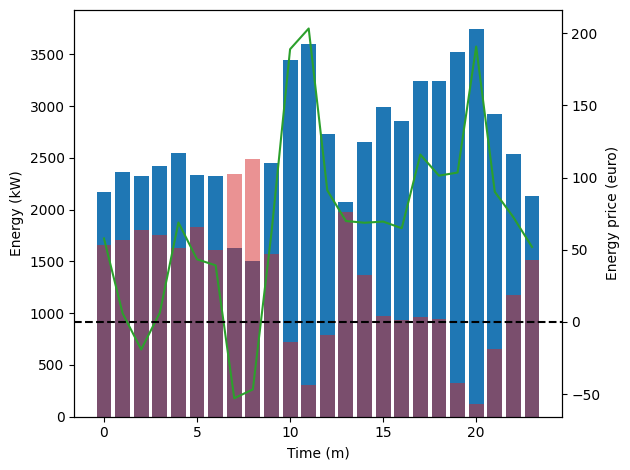

In [18]:
fig, ax1 = plt.subplots()
days = np.int64(len(episode_energy_price)/1440)

daily_take = np.array(episode_take).reshape(days, 24, 60)
daily_give = np.array(episode_give).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_take = np.sum(daily_take, axis = 2)
hourday_average_give = np.sum(daily_give, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_take = np.sum(hourday_average_take, axis = 0)
overall_hour_give = np.sum(hourday_average_give, axis = 0)
overall_hour_price = np.mean(hourday_average_price, axis = 0)

x = range(24)

color = 'k'
ax1.set_xlabel('Time (m)')
ax1.set_ylabel('Energy (kW)', color=color)
ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_hour_take, color='tab:red', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color=color)
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

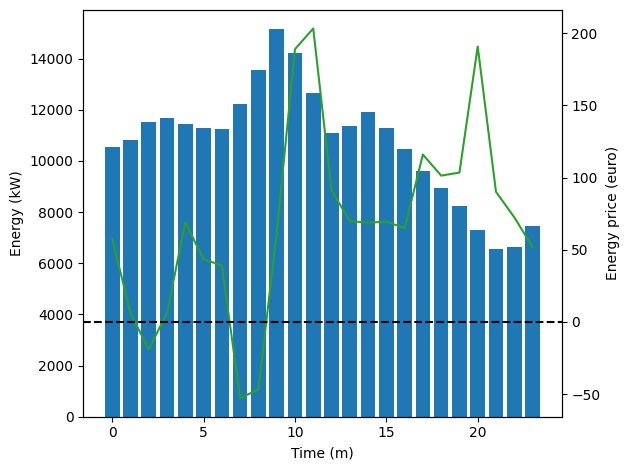

In [19]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

daily_soc = np.array(episode_soc).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_soc = np.mean(daily_soc, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_soc = np.sum(hourday_average_soc, axis = 0)
overall_hour_price = np.mean(hourday_average_price, axis = 0)

x = range(24)

color = 'k'
ax1.set_xlabel('Time (m)')
ax1.set_ylabel('Energy (kW)', color=color)
ax1.bar(x, overall_hour_soc, color='tab:blue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color=color)
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

0.39285714285714285


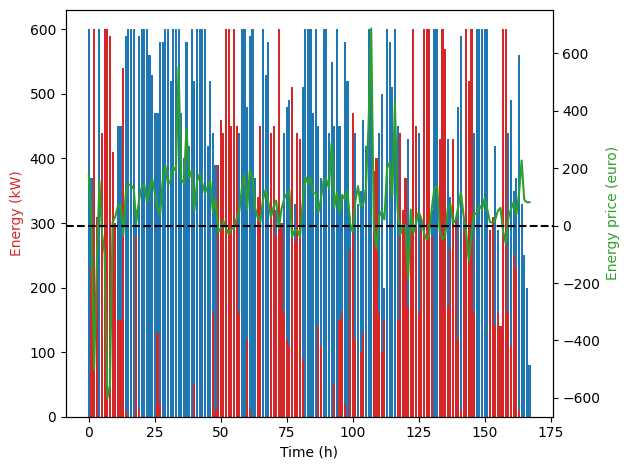

In [20]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

daily_take = np.array(episode_take).reshape(days, 24, 60)
daily_give = np.array(episode_give).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_average_take = np.sum(daily_take, axis = 2)
hourday_average_give = np.sum(daily_give, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_hour_take = hourday_average_take.flatten()
overall_hour_give = hourday_average_give.flatten()
overall_hour_price = hourday_average_price.flatten()

threshold = 0

oht_filtered = [overall_hour_take[i] if overall_hour_price[i] > threshold else 0 for i in range(len(overall_hour_take))]

print((len(oht_filtered) - oht_filtered.count(0)) / len(oht_filtered))

x = range(24*7)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Energy (kW)', color='tab:red')
ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_hour_take, color='tab:red', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# De plot is niet super duidelijk, maar dit is de prediction over een week. In het groen is de energie prijs en in rood is de

# Baseline Model

In [6]:
import pandas as pd
import os

def get_charged_minute(battery_charge: float, capacity: float, charge_per_minute: float) -> float:
    next_soc = battery_charge + charge_per_minute
    if next_soc > capacity * 0.9:
        res = (capacity * 0.9) - battery_charge
        return res
    elif next_soc < capacity * 0.1:
        res = -(battery_charge - (capacity * 0.1))
        return res
    else:
        return charge_per_minute

def get_reward(charge_per_minute, minute):
    if charge_per_minute > 0:
        price_per_kW = imb['imbalance_take_price'][minute] / 1000.0
    else:
        price_per_kW = imb['imbalance_feed_price'][minute] / 1000.0
    reward_per_minute = -(charge_per_minute * price_per_kW)
    return reward_per_minute

config = {'charge_winter': -14.783232243425344, 
 'discharge_winter': 54.465705741287394, 
 'charge_summer': 16.19267672872887, 
 'discharge_summer': 50.20564418513649, 
 'charge_winter_night': 19.830706694089418, 
 'discharge_winter_night': 20.185944997256925, 
 'charge_summer_night': 5.56931301624121, 
 'discharge_summer_night': 20.15069553603697}

charge_per_minute = 600.0 / 60.0

action_to_charge = {
    0 : charge_per_minute,
    1 : -charge_per_minute,
    2 : 0
}

# Night is 0<= hour <6

# Define the winter and summer periods
winter_start = pd.to_datetime('10/01', format='%m/%d').dayofyear
winter_end = pd.to_datetime('03/01', format='%m/%d').dayofyear

# Load data
current_folder = globals()['_dh'][0]
data_path = os.path.join(current_folder, "./data/imb_clean.csv")
imb = pd.read_csv(data_path)

days = 60
start_minute = 0
total_reward_baseline = 0
capacity = 6000.0
battery_charge = capacity * 0.5
action = 0
# Charge rate in kilo Watt per hour = kWh
charge_rate = 600.0

# kilo Watt hour per minute
kW_min = charge_rate / 60.0

episode_base_give = []
episode_base_take = []
episode_base_reward = []

run_time = 1440 * days
# Baseline Model performance
for i in range(run_time):
    m = start_minute + i
    row = imb.iloc[m]
    # Determine if the date is in winter or summer
    if (row['day_of_year'] >= winter_start) or (row['day_of_year'] < winter_end):
        if 0 <= row['hour_of_day'] < 6:
            if row['high_feed_price'] >= config['discharge_winter_night']:
                action = 1
            elif row['low_take_price'] <= config['charge_winter_night']:
                action = 0
            else:
                action = 2
        else:
            if row['high_feed_price'] >= config['discharge_winter']:
                action = 1
            elif row['low_take_price'] <= config['charge_winter']:
                action = 0
            else:
                action = 2            
    else:
        if 0 <= row['hour_of_day'] < 6:
            if row['high_feed_price'] >= config['discharge_summer_night']:
                action = 1
            elif row['low_take_price'] <= config['charge_summer_night']:
                action = 0
            else:
                action = 2  
        else:
            if row['high_feed_price'] >= config['discharge_summer']:
                action = 1
            elif row['low_take_price'] <= config['charge_summer']:
                action = 0
            else:
                action = 2  

    charge_per_minute = get_charged_minute(battery_charge, capacity, action_to_charge[action])
    battery_charge = battery_charge + charge_per_minute
    total_reward_baseline+=get_reward(charge_per_minute, m)
    episode_base_reward.append(get_reward(charge_per_minute, m))

    # Store action and dates
    if action == 0:
        episode_take.append(kW_min)
        episode_give.append(0)
    elif action == 1:
        episode_take.append(0)
        episode_give.append(kW_min)
    else:
        episode_give.append(0)
        episode_take.append(0)
    

print(total_reward_baseline)


13951.095499999828


# Comparing Baseline and DQN

Improvement over baseline: -6.92156079340065%


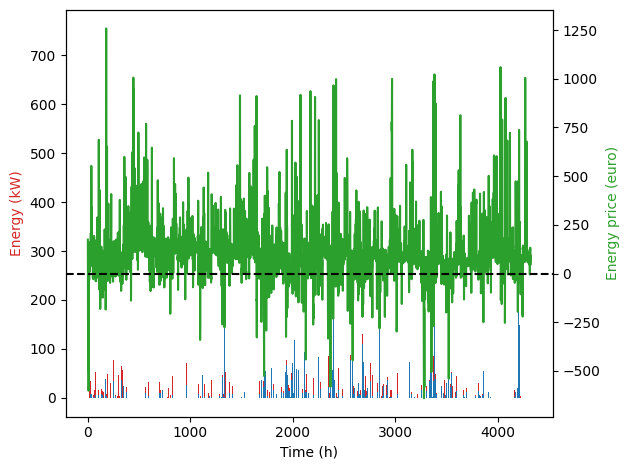

In [7]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

print("Improvement over baseline: {}%".format((total_reward / total_reward_baseline - 1) * 100))

dqn_reward = np.array(episode_reward).reshape(days, 24, 60)
baseline_reward = np.array(episode_base_reward).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_dqn_reward = np.sum(dqn_reward, axis = 2)
hourday_baseline_reward = np.sum(baseline_reward, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_dqn_reward = hourday_dqn_reward.flatten()
overall_baseline_reward = hourday_baseline_reward.flatten()
overall_hour_price = hourday_average_price.flatten()

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Energy (kW)', color='tab:red')
# ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_dqn_reward, color='tab:red', alpha=1)
ax1.bar(x, overall_baseline_reward, color='tab:blue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# De plot is niet super duidelijk, maar dit is de prediction over een week. In het groen is de energie prijs en in rood is de

Improvement over baseline: 31.43697425052232%


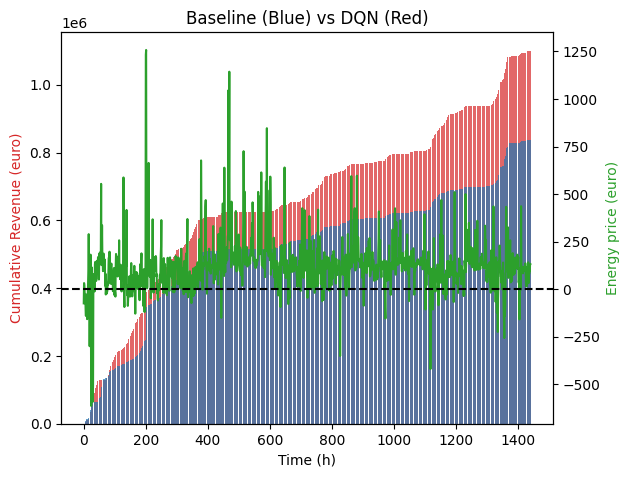

In [7]:
fig, ax1 = plt.subplots()

days = np.int64(len(episode_energy_price)/1440)

print("Improvement over baseline: {}%".format((total_reward / total_reward_baseline - 1) * 100))

cum_dqn_reward = [sum(episode_reward[:i+1]) for i in range(len(episode_reward))]
cum_baseline_reward = [sum(episode_base_reward[:i+1]) for i in range(len(episode_base_reward))]


dqn_reward = np.array(cum_dqn_reward).reshape(days, 24, 60)
baseline_reward = np.array(cum_baseline_reward).reshape(days, 24, 60)
daily_price = np.array(episode_energy_price).reshape(days, 24, 60)

hourday_dqn_reward = np.sum(dqn_reward, axis = 2)
hourday_baseline_reward = np.sum(baseline_reward, axis = 2)
hourday_average_price = np.mean(daily_price, axis = 2)

overall_dqn_reward = hourday_dqn_reward.flatten()
overall_baseline_reward = hourday_baseline_reward.flatten()
overall_hour_price = hourday_average_price.flatten()

x = range(24*days)

color = 'k'
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Cumulative Revenue (euro)', color='tab:red')
# ax1.bar(x, overall_hour_give, color='tab:blue', alpha=1)
ax1.bar(x, overall_dqn_reward, color='tab:red', alpha=0.7)
ax1.bar(x, overall_baseline_reward, color='tab:blue', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'k'
ax2.set_ylabel('Energy price (euro)', color='tab:green')
ax2.plot(overall_hour_price, color='tab:green')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Baseline (Blue) vs DQN (Red)")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

# Q-Learning Agent

In [ ]:
env = gym.make('gym_environment:gym_environment/GridWorld', render_mode=None, max_episode_steps=300)
env = FlattenObservation(env)

n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

# Q-table zero init
q_table = np.zeros((n_observations, n_actions))
print(q_table)

n_episodes = 10000

# init exploration probablity
exploration_prob = 1

# exploraation decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum exploration probability
min_exploration_prob = 0.01

# discount factor
gamma = 0.99

# learning rate
lr = 0.1

# Q-Learning Training

In [ ]:
total_rewards_episode = list()

# Interating over the episodes
for e in range(n_episodes):
    # first state
    current_state, _ = env.reset()
    done = False

    # total reward
    total_reward = 0
    while not done:
        # implementing e-random
        if np.random.uniform(0,1) < exploration_prob:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[current_state,:], axis=1)
            if action.size > 1:
                action = random.choice(action)
        # Step in the env
        next_state, reward, terminated, truncated, info = env.step(action)

        # Update the Q table
        q_table[current_state, action] = (1-lr) * q_table[current_state, action] + lr*(reward + gamma*np.max(q_table[next_state,:]))

        total_reward = total_reward + reward

        done = terminated or truncated

        if done:
            next_state = None
        else:
            current_state = next_state 
    exploration_prob = max(min_exploration_prob, np.exp(-exploration_decreasing_decay*e))
    total_rewards_episode.append(total_reward)
        

In [ ]:
env = gym.make('gym_environment:gym_environment/GridWorld', render_mode='human', max_episode_steps=300)
env = FlattenObservation(env)

episodes = 10

for ep in range(episodes):
    current_state, info = env.reset()
    terminated = False

    while not terminated:
        action = np.argmax(q_table[current_state,:], axis=1)
        if action.size > 1:
            action = random.choice(action)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            current_state = next_state

        env.render()
